In [ ]:
!git clone https://github.com/Im-JihyunKim/2024_LG_ES_RNN  # colab 사용 시

In [ ]:
# Colab 사용 시 실행
# Local PC로 실습하는 경우에는 실행 X, 단 작업경로를 2024_LG_ES_RNN으로 맞춰주기
%cd /content/2024_LG_ES_RNN

In [1]:
# !pip install IPython
from IPython.display import Image

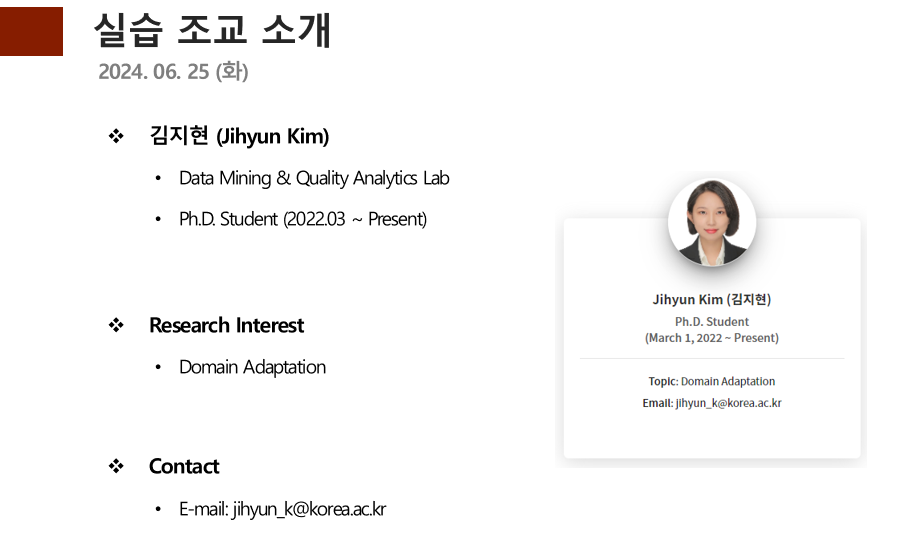

In [2]:
Image('./images/img1.PNG')

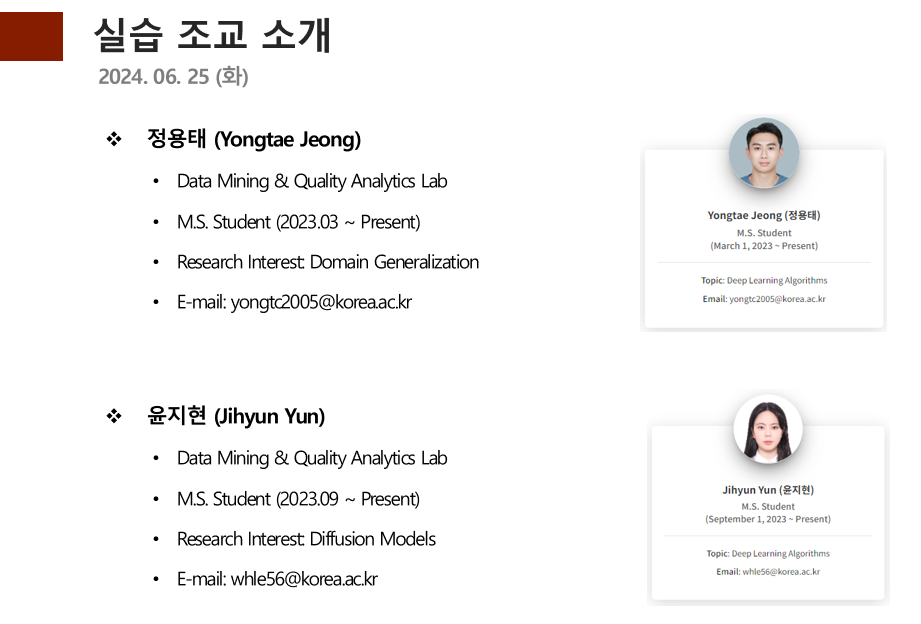

In [3]:
Image('./images/img2.PNG')

----------

# Task: Time Series Forecasting with RNN, LSTM, and GRU

#### Jupyter Notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

## 1. 필요 모듈(라이브러리) 호출

In [1]:
''' 데이터 처리를 위한 기본 모듈 및 시각화 모듈'''
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

'''RNN 기반 데이터 분석을 위한 딥러닝 모듈'''
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

''' 결과 평가용 모듈 '''
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true+1e-10))*100
    return mape
    
import warnings
warnings.filterwarnings(action='ignore') 

## 2. 학습 전 준비

### GPU 확인 및 사용할 device 설정

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Seed/Random state 고정

In [3]:
# 똑같은 결과를 얻기 위한 시드 고정
def set_seed(seed:int=0):
    torch.manual_seed(seed) # torch cpu seed 고정
    torch.cuda.manual_seed(seed) # torch gpu seed 고정
    torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed) # numpy seed 고정
    random.seed(seed)    # python seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed)

## Task 수행을 위해 필요한 환경설정 (Configurations)
- 데이터 로드 - 모델 정의 - 모델 학습 알고리즘 정의 - 모델 평가 전반에 필요한 인자들
- 즉, Task 수행을 위한 하이퍼파라미터를 사전에 정의

In [4]:
# 본 튜토리얼에서는 Python의 Dictionary 형태로 정의 ('Key': value)
# .py 파일을 이용한 모델링을 수행하는 경우, argparser 이용 (https://wikidocs.net/73785 참고)

configs = {
    ### 0. 기본 설정 ###
        # device 설정
        # seed (정수 형태)

    ### 1. Data 관련 하이퍼파라미터 ###
        # 데이터가 있는 폴더 (data_dir)
        # Train, Valid, Test는 어느 비율로 나눌 것인지 (train_ratio, valid_ratio, ...)
        # Batch size는 얼마나 할지 (batch_size)
        # 데이터에 대한 augmentation 인자 (aug_prob, jitter, scale, ...)
    
    ### 2. Model 관련 하이퍼파라미터 ###
        # 모델의 차원 (hidden_dim)
        # 모델 층은 얼마나 쌓을 것인지 (num_layers)
        # RNN의 경우 양방향성을 가질 것인지 (bidirectional)
        # 과적합 (overfitting) 방지를 위한 여러 기법들 (dropout_rate, ...)

    ### 3. Model Training 관련 하이퍼파라미터 ###
        # 어떤 optimizer를 사용할지 (optimizer)
        # 학습율은 어느 정도로 할 지 (learning_rate/lr)
        # 최적화와 관하여 규제 여부 (momentum, weight_decay, ...)
        # 학습을 몇 번 반복할 지 (num_epochs)
        # 학습이 완료된 후 모델 파라미터를 어디에 저장할 지 (save_dir)
}

In [5]:
basic_configs = {'device': 'cuda' if torch.cuda.is_available() else 'cpu',
                 'seed': 0}

configs.update(basic_configs)   # 기존에 정의했던 configs 빈 껍데기에 basic_configs 값을 추가
configs

{'device': 'cuda', 'seed': 0}

## 3. Dataset 및 Dataloader 정의

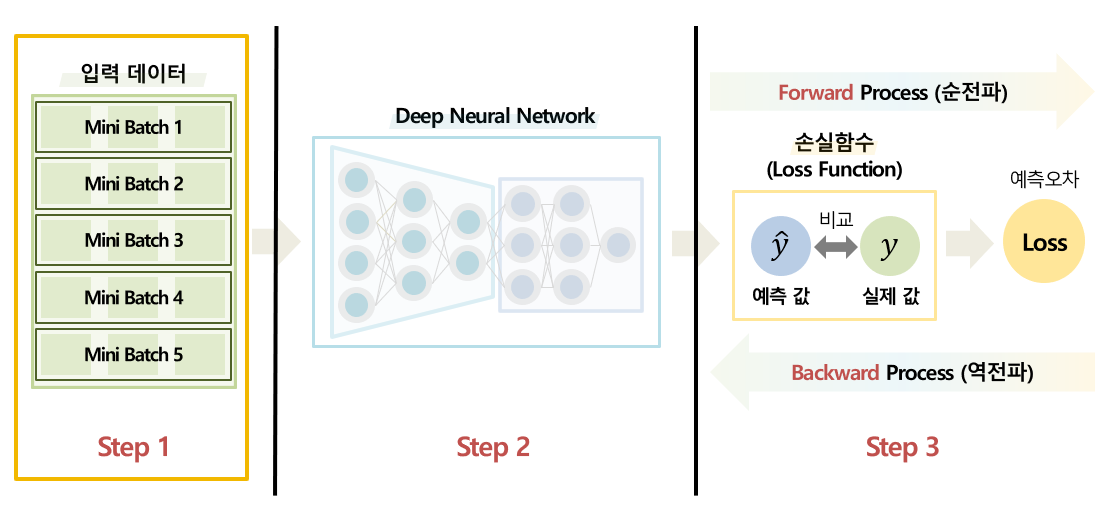

In [8]:
Image('./images/dataset.PNG')

### 실습 데이터셋: [Electricity Transformer Dataset(ETDataset)](https://github.com/zhouhaoyi/ETDataset)
- Oil temperature를 예측 (forecasting) 하기 위한 데이터셋
    - 오일의 온도는 전기 변압기의 상태를 반영한다는 특성을 가짐. 이에 따라 변압기의 오일 온도가 안전한지 예측하여 불필요한 낭비를 방지
- 2년 간의 기간 동안 수집되었으며, 각 데이터 관측치는 시간(h) 단위로 수집됨

<br/>

- 입력 변수 (X): 6종류의 외부 전력 부하 기능 (externel power load features)
- 출력 변수 (Y): Oil temperature

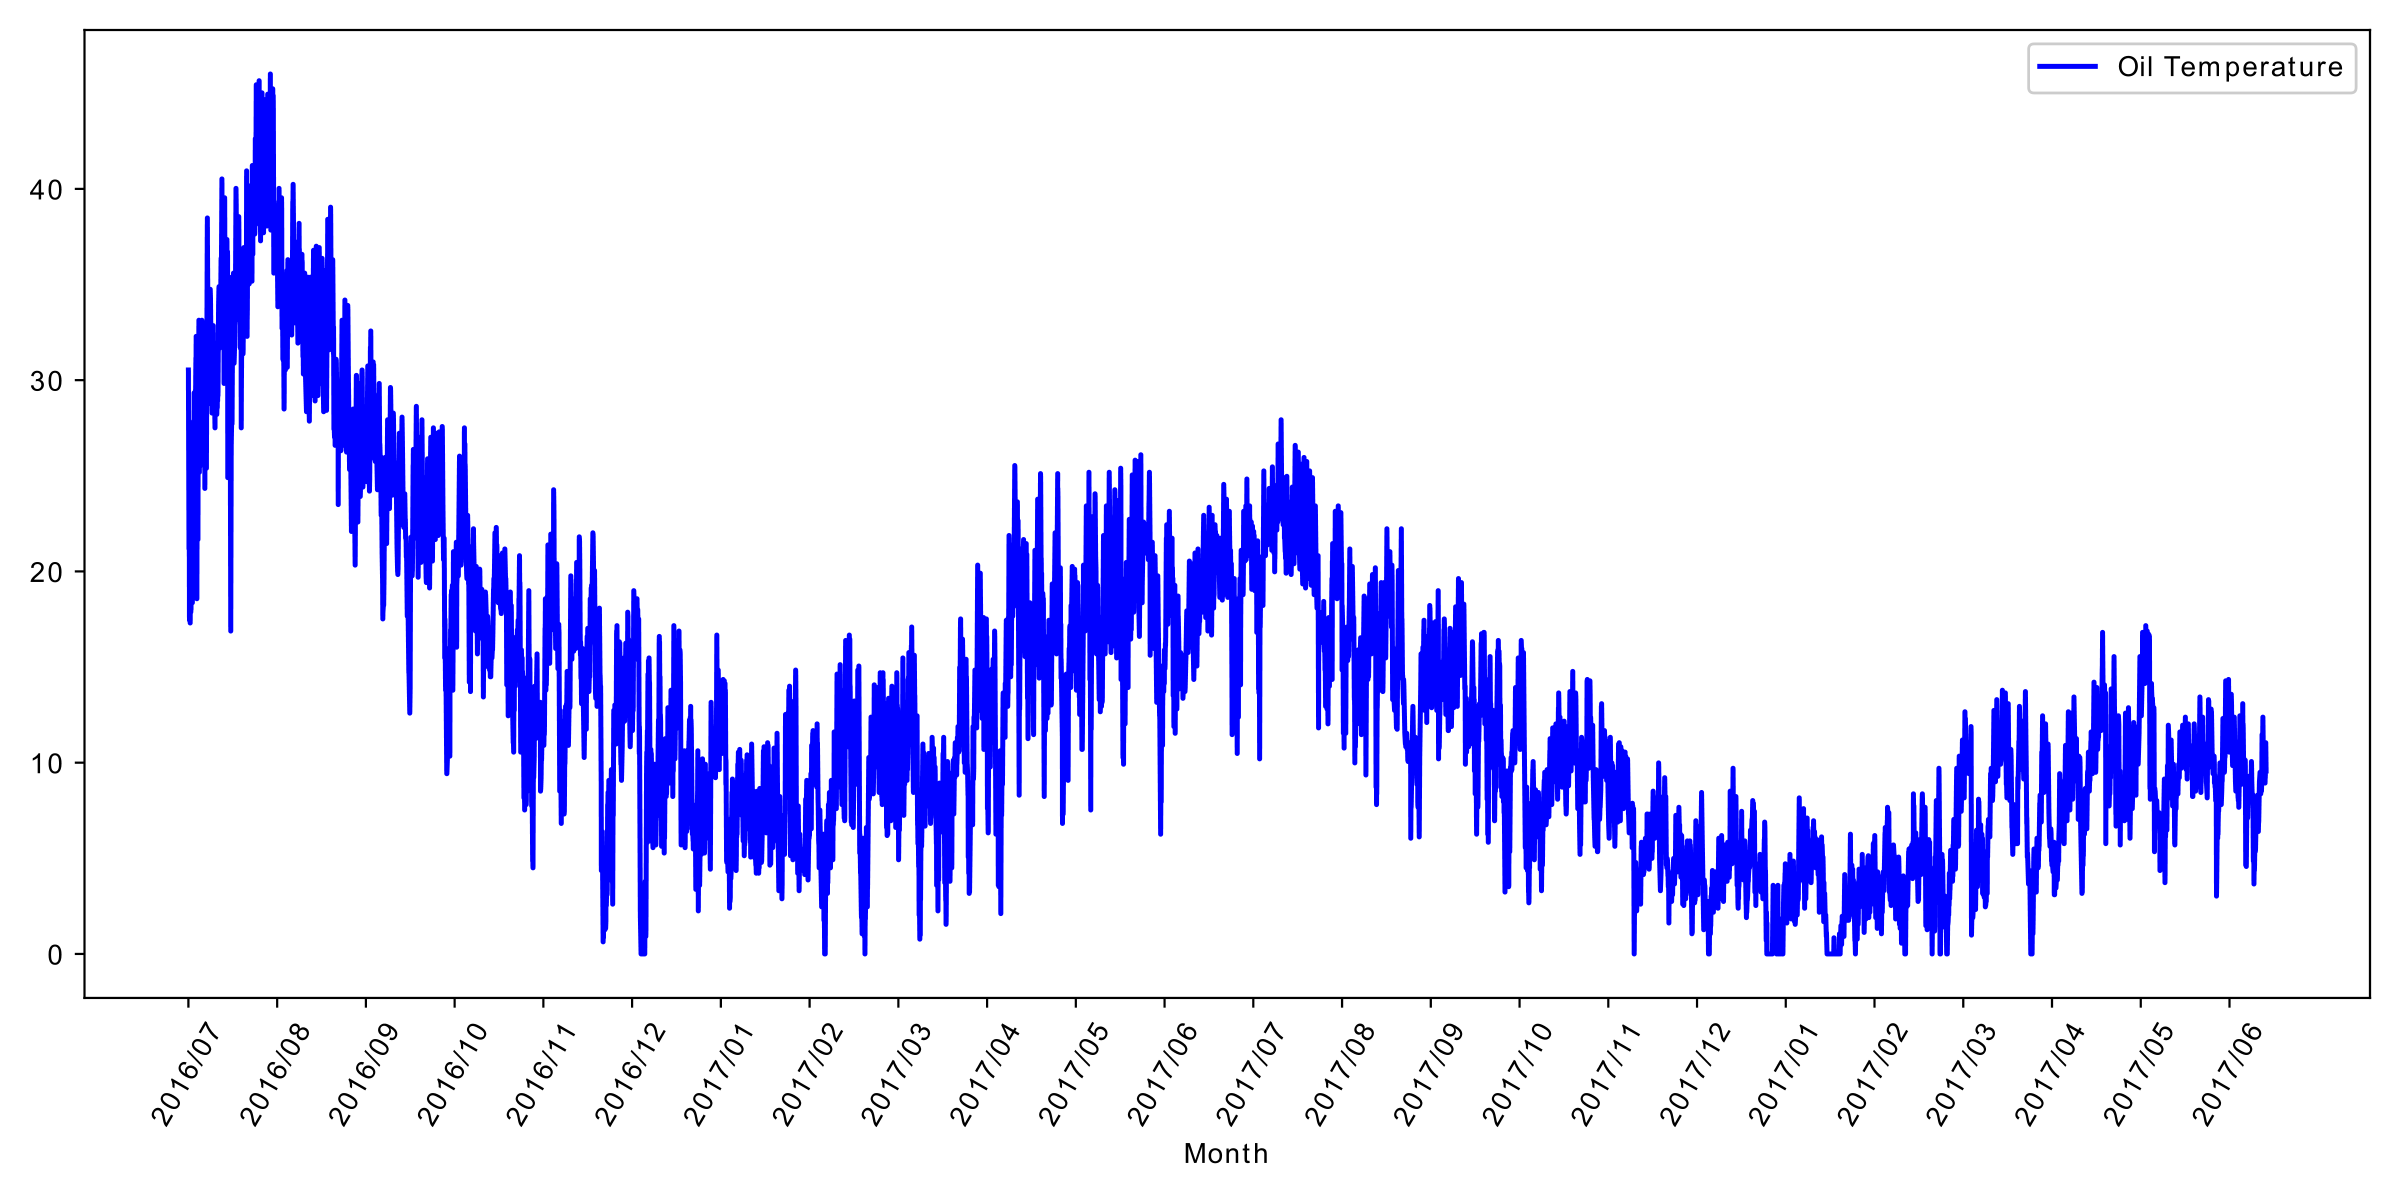

In [11]:
Image('./images/ETT1.PNG')

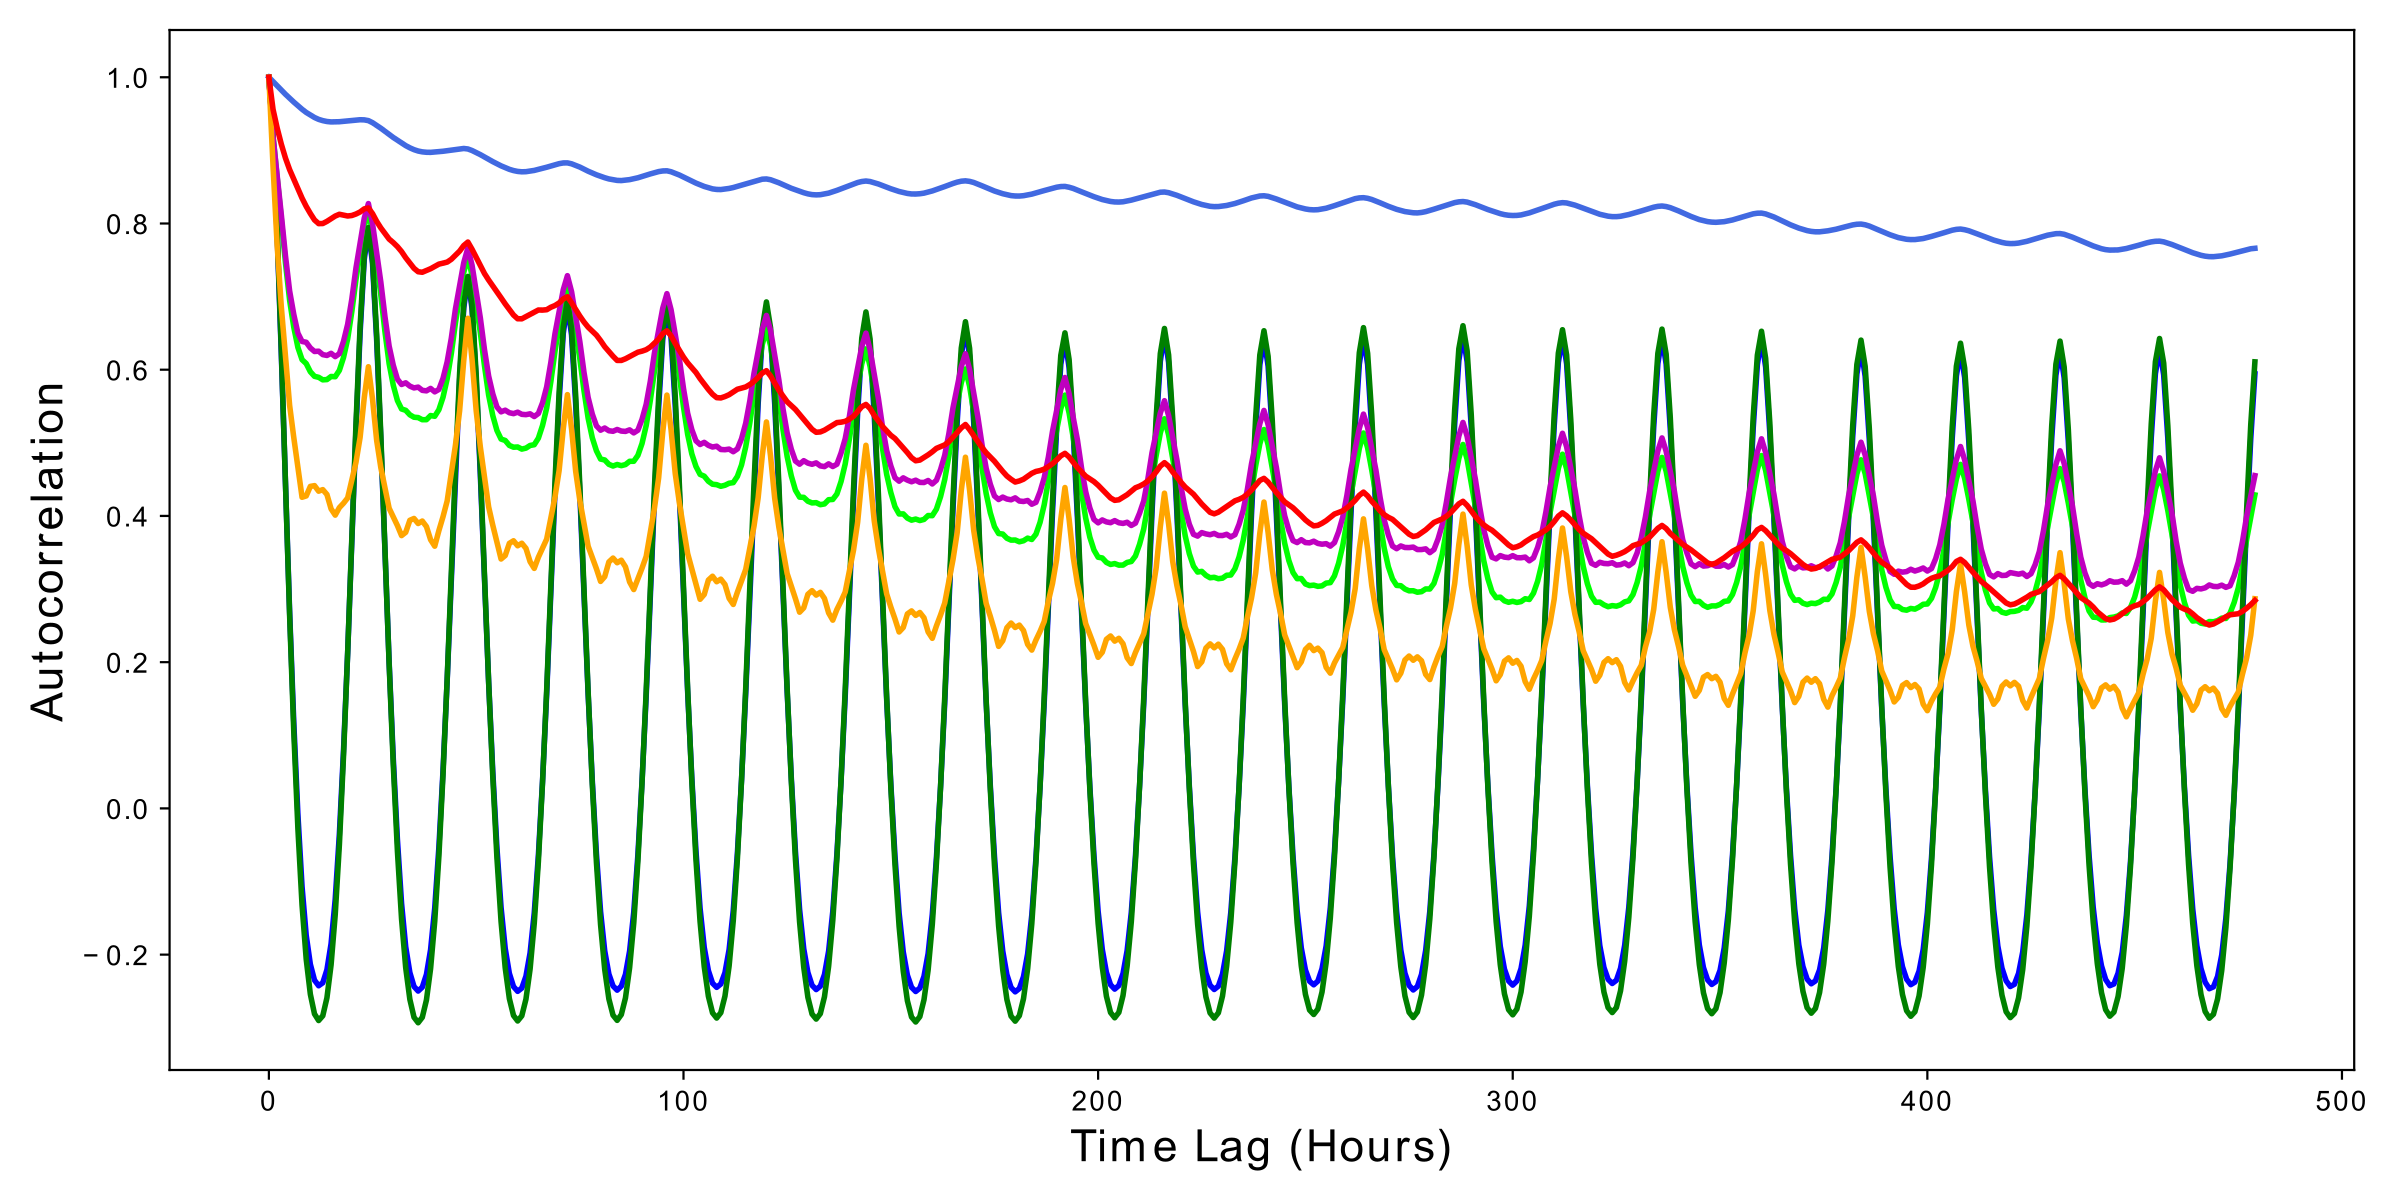

In [12]:
Image('./images/ETT2.PNG')

- 모든 변수에 대한 자기 상관관계 (Auto correlation) 그래프
    - 시간에 따른 자기 상관 계수를 나타낸 것이며, 자기 상관이란 시계열 데이터의 값이 시간에 따라 어떻게 관련되어 있는지를 나타냄 (t시점의 값이 t+k 시점의 값과 어떤 관계를 가지는가)
- 파란색 선은 oil temperature이며, 단기적으로 특정 패턴이 나타남을 볼 수 있음
- 이외 다른 변수들(입력 변수)은 일별 패턴 (24시간)과 주별 패턴(7일)을 보여줌

!wget https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv

In [9]:
df = pd.read_csv('./data/ETT/ETTh1.csv'); df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


- date: The recorded __date__
- HUFL: **H**igh **U**se**F**ul **L**oad
- HULL: **H**igh **U**sse**L**ess **L**oad
- MUFL: **M**iddle **U**se**F**ul **L**oad
- MULL: **M**iddle **U**sse**L**ess **L**oad
- LUFL: **L**ow **U**se**F**ul **L**oad
- LULL: **L**ow **U**sse**L**ess **L**oad

In [13]:
df.date.dtype

dtype('O')

In [10]:
# datetime을 'datetime' 자료형으로 변환
df.date = pd.to_datetime(df.date)
df = df.sort_values('date')
df.date.dtype

dtype('<M8[ns]')

In [10]:
# 약 725일 간 수집된 데이터임을 알 수 있음
df.shape[0]//24  # 725일

725

In [11]:
X = df.loc[:, 'HUFL':'LULL'].values  # 'date'와 'OT' 제거
y = df.loc[:, 'OT'].values
print(X.shape, y.shape)

(17420, 6) (17420,)


### 3-2. 데이터 전처리 (1)

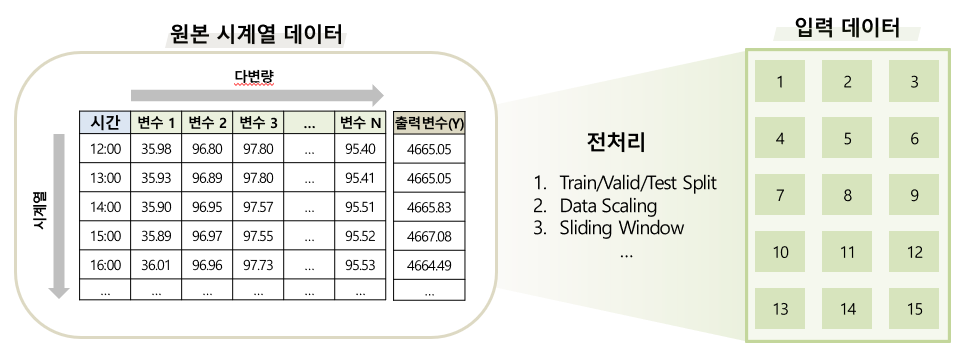

In [17]:
Image('./images/preprocess.PNG')

#### Train / Valid / Test Split

In [12]:
data_configs = {
    'valid_ratio':0.2,
    'test_ratio':0.2,
}

configs.update(data_configs)

In [13]:
"""Train/Valid/Test 분리"""
# shuffle False에 주의! 시계열 데이터는 일반적으로 시간 순으로 train/valid/test를 분리

# Step 1. Train과 Test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=configs['test_ratio'], shuffle=False)

# Step 2. Train 내에서 valid 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=configs['valid_ratio'], shuffle=False)

In [12]:
print(f" 학습 일자: {X_train.shape[0]//24}일" "\n", 
      f"검증 일자: {X_valid.shape[0]//24}일" "\n", 
      f"평가 일자: {X_test.shape[0]//24}일" "\n")

 학습 일자: 464일
 검증 일자: 116일
 평가 일자: 145일



#### Data Scaling
- 입력 값의 스케일이 유사해지도록 맞추는 작업
- **Train 데이터의 정보만을 활용하여 scaling 수행해야 함에 주의**
    - Train 데이터의 통계량(min,max,mean,std)을 이용하여 Valid/Test에 scaling 수행

In [14]:
data_configs = {
    'scaler':'standard'  # choices=(minmax, standard)
}

configs.update(data_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'valid_ratio': 0.2,
 'test_ratio': 0.2,
 'scaler': 'standard'}

In [15]:
# Step 1. Scaler 정의
X_scaler = StandardScaler() if configs['scaler']=='standard' else MinMaxScaler()
y_scaler = StandardScaler() if configs['scaler']=='standard' else MinMaxScaler()

# Step 2. 학습 (TRAIN) 데이터의 통계 정보만으로 scaler를 정의 (fit) 해야 함에 주의
X_scaler.fit(X_train)
y_scaler.fit(y_train.reshape(-1,1))

# Step 3. transform 수행
X_train, X_valid, X_test = X_scaler.transform(X_train), X_scaler.transform(X_valid), X_scaler.transform(X_test)
y_train, y_valid, y_test = y_scaler.transform(y_train.reshape(-1,1)), y_scaler.transform(y_valid.reshape(-1,1)), y_scaler.transform(y_test.reshape(-1,1))

### 3-2. 데이터 전처리 (2)
#### Sliding Window
- 약 725일 간 수집된 데이터이며, 각 관측치는 시간 단위로 수집됨
- 자기 상관 그래프를 기반으로, 7일 간의 데이터 패턴을 학습하도록 함b

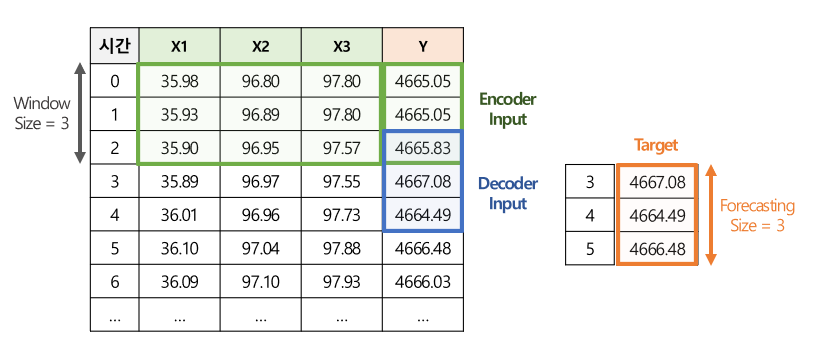

In [73]:
Image('./images/seq2seq-input.PNG')

In [16]:
data_configs = {
    'window_size': 24*7,     # 7일
    'forecasting_size':24*7, # 7일
    'stride' : 1,
}
configs.update(data_configs)

In [17]:
def sliding_window_forecasting(X, y, window_size:int, stride_size:int, forecasting_size:int):
    enc_input, dec_input, targets = [], [], []
    for start in range(0, y.shape[0]-(window_size+forecasting_size)+1, stride_size):
        x_enc = X[start : start+window_size]
        y_window = y[start : start+window_size+forecasting_size]
        
        y_enc = y_window[:window_size]
        y_dec = y_window[window_size-1 : window_size+forecasting_size-1]
        target = y_window[window_size : window_size+forecasting_size:]

        enc_input.append(np.concatenate([x_enc, y_enc.reshape(-1,1)], axis=-1))
        dec_input.append(y_dec)
        targets.append(target)

    return np.array(enc_input), np.array(dec_input), np.array(targets)

In [18]:
## 데이터의 차원 확인 ##

enc_train, dec_train, trg_train = sliding_window_forecasting(X_train, y_train, 
                                                            configs['window_size'], 
                                                            configs['stride'], 
                                                            configs['forecasting_size'])

enc_valid, dec_valid, trg_valid = sliding_window_forecasting(X_valid, y_valid, 
                                                            configs['window_size'], 
                                                            configs['stride'], 
                                                            configs['forecasting_size'])

enc_test, dec_test, trg_test = sliding_window_forecasting(X_test, y_test, 
                                                            configs['window_size'], 
                                                            configs['stride'], 
                                                            configs['forecasting_size'])


print(f"학습 데이터의 차원: 인코더 입력 {enc_train.shape}, 디코더 입력 {dec_train.shape}, Target 데이터 {trg_train.shape}")
print(f"검증 데이터의 차원: 인코더 입력 {enc_valid.shape}, 디코더 입력 {dec_valid.shape}, Target 데이터 {trg_valid.shape}")
print(f"평가 데이터의 차원: 인코더 입력 {enc_test.shape}, 디코더 입력 {dec_test.shape}, Target 데이터 {trg_test.shape}")

학습 데이터의 차원: 인코더 입력 (10813, 168, 7), 디코더 입력 (10813, 168, 1), Target 데이터 (10813, 168, 1)
검증 데이터의 차원: 인코더 입력 (2453, 168, 7), 디코더 입력 (2453, 168, 1), Target 데이터 (2453, 168, 1)
평가 데이터의 차원: 인코더 입력 (3149, 168, 7), 디코더 입력 (3149, 168, 1), Target 데이터 (3149, 168, 1)


### 3-3. Dataset

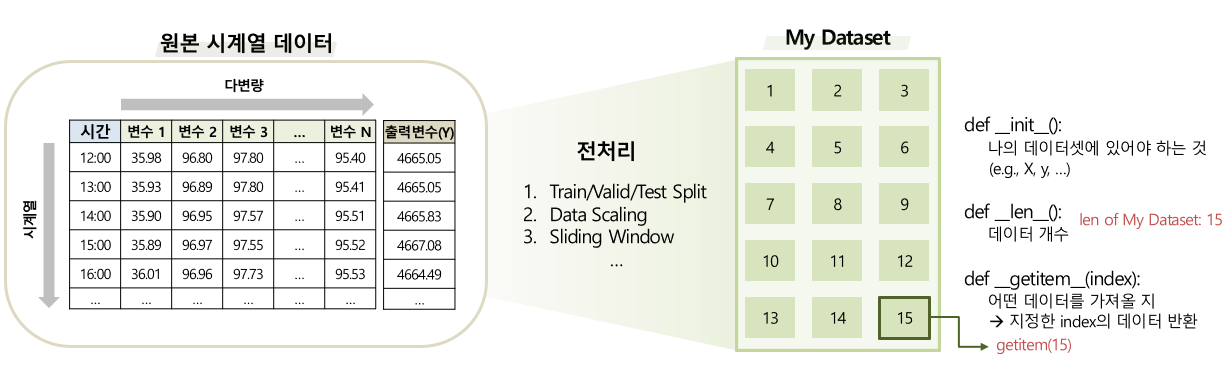

In [75]:
Image('./images/custom_dataset.PNG')

In [19]:
class TSDataset(Dataset):
    def __init__(self, configs, enc_input, dec_input, targets):
        self.configs = configs
        self.enc_input = torch.Tensor(enc_input)
        self.dec_input = torch.Tensor(dec_input)
        self.targets = torch.Tensor(targets)
    
    def __getitem__(self, idx):
        return {'enc_input': self.enc_input[idx].float(),
                'dec_input': self.dec_input[idx].float(),
                'targets':self.targets[idx].float()}
    
    def __len__(self):
        return len(self.enc_input)

    @property
    def input_dim(self):
        # input dimension (차원)을 반환
        return self.enc_input.shape[-1]

In [19]:
print(f"학습 데이터의 수: {len(TSDataset(configs, enc_train, dec_train, trg_train))}")
print(f"검증 데이터의 수: {len(TSDataset(configs, enc_valid, dec_valid, trg_valid))}")
print(f"평가 데이터의 수: {len(TSDataset(configs, enc_test, dec_test, trg_test))}")

학습 데이터의 수: 10813
검증 데이터의 수: 2453
평가 데이터의 수: 3149


### DataLoader 정의

In [20]:
data_configs = {
    'batch_size':64
}
configs.update(data_configs)

In [21]:
def get_dataloader(configs):
    trainset = TSDataset(configs, enc_train, dec_train, trg_train)
    validset = TSDataset(configs, enc_valid, dec_valid, trg_valid)
    testset = TSDataset(configs, enc_test, dec_test, trg_test)

    trainloader = DataLoader(trainset, batch_size=configs['batch_size'], shuffle=True, drop_last=False)
    validloader = DataLoader(validset, batch_size=configs['batch_size'], shuffle=False, drop_last=False)
    testloader = DataLoader(testset, batch_size=configs['batch_size'], shuffle=False, drop_last=False)

    return trainloader, validloader, testloader

In [22]:
trainloader, validloader, testloader = get_dataloader(configs)

# 학습 데이터셋의 입력 (X) 데이터의 차원 확인
# [데이터 개수, window size = sequence length, dimension of samples]
# [N, L, H_in]
trainloader.dataset.enc_input.shape

torch.Size([10813, 168, 7])

---------------------------

## 4. 모델 정의
- Sequence to Sequence with RNN-based Model (Many to Many)

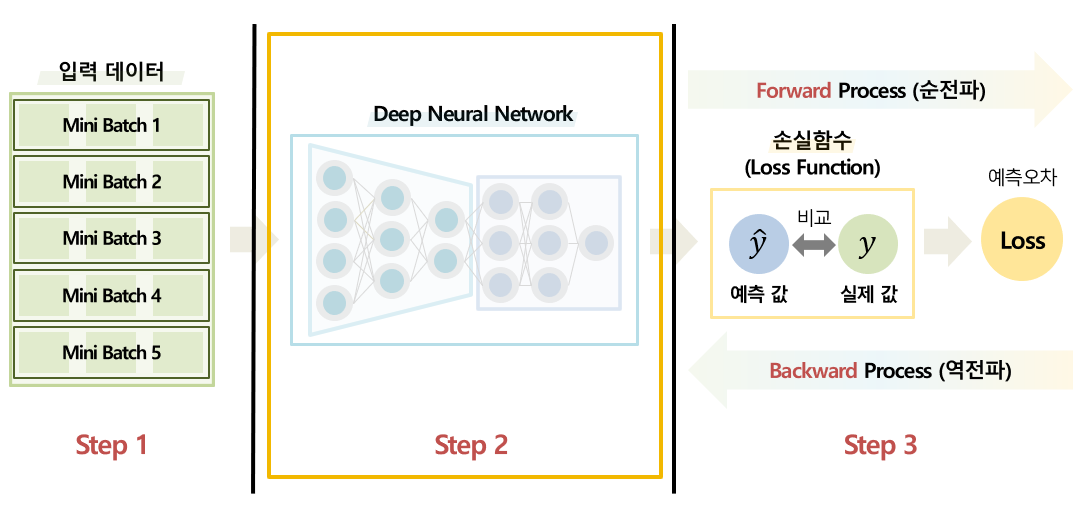

In [76]:
Image('./images/model.PNG')

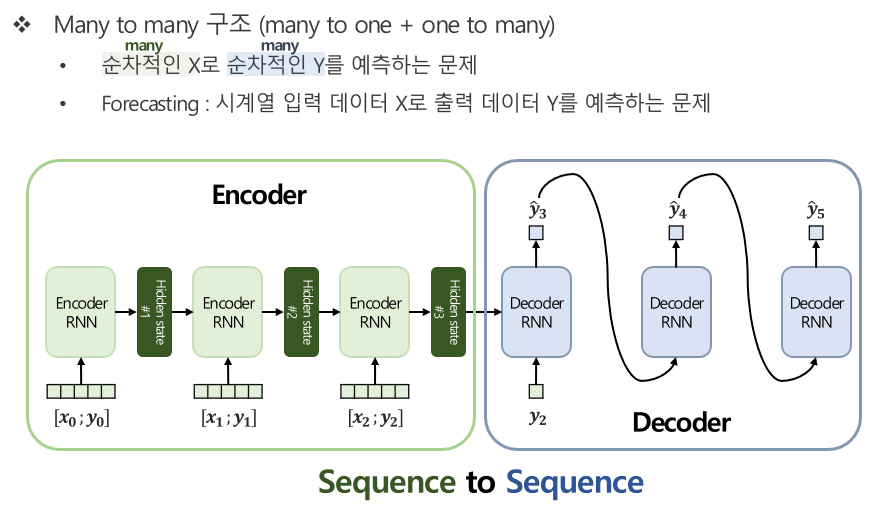

In [77]:
Image('./images/seq2seq.PNG')

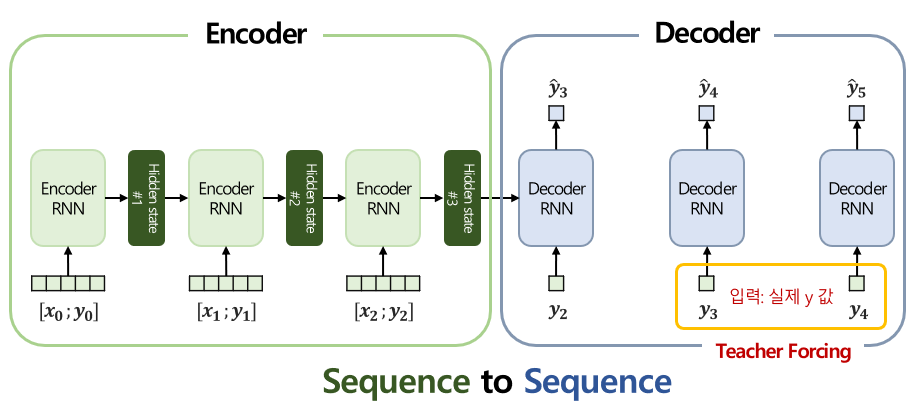

In [78]:
Image('./images/seq2seq-teacher-forcing.PNG')

In [49]:
model_configs = {
    'rnn_type': 'LSTM',        # 'RNN', 'LSTM', 'GRU' 중 하나 선택 (str)
    'hidden_size': 64,        # RNN 레이어가 가지는 은닉 노드 수 (int)
    'num_layers': 2,          # RNN 레이어를 몇 개 쌓을지 (int)
    'bidirectional': True,    # 단방향/양방향 여부 (bool: True or False)
    'dropout_rate': .1,       # dropout

    'teacher_force_prob': .5  # teacher force를 수행할 확률
}

configs.update(model_configs)

In [90]:
class Encoder(nn.Module):
    def __init__(self, configs, input_dim):
        super(Encoder, self).__init__()
        self.configs = configs
        self.input_dim = input_dim
        self.hidden_size = configs['hidden_size']      # 64
        self.num_layers = configs['num_layers']        # 1
        self.bidirectional = configs['bidirectional']  # True
        self.dropout_rate = configs['dropout_rate']

        self.rnn_type = configs['rnn_type']
        rnn_type_list = ['RNN', 'LSTM', 'GRU']
        assert self.rnn_type in rnn_type_list  # RNN type model이 RNN, LSTM, GRU 중 하나여야 함

        self.encoder = getattr(nn, self.rnn_type)(
            input_size = self.input_dim,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True,
            bidirectional = self.bidirectional,
            dropout = self.dropout_rate
        )

    def forward(self, enc_input):
        # Initial hidden state 초기화
        num_direction = self.num_layers*2 if self.bidirectional else self.num_layers
        h0 = torch.zeros(num_direction, enc_input.size(0), self.hidden_size, device=enc_input.device)

        if self.rnn_type == 'LSTM':
            # lstm의 경우 initial cell state 초기화
            c0 = torch.zeros(num_direction, enc_input.size(0), self.hidden_size, device=enc_input.device)

        # 인코더의 states를 출력하여 반환 (디코더의 init states를 encoder의 것으로 초기화하기 위함)
        init_state = (h0, c0) if self.rnn_type == 'LSTM' else h0
        enc_out, enc_states = self.encoder(enc_input, init_state)

        # 양방향 RNN인 경우: 마지막 layer의 단방향, 역방향 layer state를 결합 (concatenate)
        # 단방향 RNN인 경우: 가장 마지막 timestep에 대한 state 값 
        if self.rnn_type == 'LSTM':
            enc_states = list(enc_states)
            enc_states[0] = enc_states[0][:self.num_layers]  # decoder num_layers만큼 indexing
            enc_states[1] = enc_states[1][:self.num_layers]
            enc_states = (enc_states[0], enc_states[1])
        else:
            enc_states = enc_states[:self.num_layers]

        return enc_states

In [91]:
class Decoder(nn.Module):
    def __init__(self, configs):
        super(Decoder, self).__init__()
        self.configs = configs
        self.hidden_size = configs['hidden_size']      # 64
        self.num_layers = configs['num_layers']        # 1
        self.dropout_rate = configs['dropout_rate']

        self.rnn_type = configs['rnn_type']
        rnn_type_list = ['RNN', 'LSTM', 'GRU']
        assert self.rnn_type in rnn_type_list  # RNN type model이 RNN, LSTM, GRU 중 하나여야 함

        self.decoder = getattr(nn, self.rnn_type)(
            input_size = 1,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True,
            bidirectional = False,  # 미래 값 예측을 해야 하므로 미래 정보를 사용하는 것은 적절하지 않음
            dropout = self.dropout_rate
        )

        self.regressor = nn.Linear(in_features=self.hidden_size, out_features=1)

    def forward(self, dec_input, states):
        out, states = self.decoder(dec_input, states)
        pred = self.regressor(out)

        return pred, states

In [151]:
class Seq2Seq(nn.Module):
    def __init__(self, configs, input_dim):
        super(Seq2Seq, self).__init__()

        self.configs = configs
        self.encoder = Encoder(configs, input_dim)
        self.decoder = Decoder(configs)

    def forward(self, enc_input, dec_input, teacher_forcing_prob):
        states = self.encoder(enc_input)

        # initial decoder input
        _dec_input = dec_input[:, 0, :].unsqueeze(-1)

        # Store decoder outputs
        preds = torch.zeros(dec_input.size(0), self.configs['forecasting_size'], 1).to(dec_input.device)
        for t in range(1, self.configs['forecasting_size']):
            pred, states = self.decoder(_dec_input, states)
            preds[:, t, :] = pred.squeeze(1)

            # set up input for next timestep
            teacher_force = torch.rand(1).item() < teacher_forcing_prob
            _dec_input = dec_input[:, t, :].unsqueeze(-1) if teacher_force else pred

        return preds

In [131]:
model = Seq2Seq(configs, trainloader.dataset.input_dim)
model

Seq2Seq(
  (encoder): Encoder(
    (encoder): LSTM(7, 64, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  )
  (decoder): Decoder(
    (decoder): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.1)
    (regressor): Linear(in_features=64, out_features=1, bias=True)
  )
)

----------------------

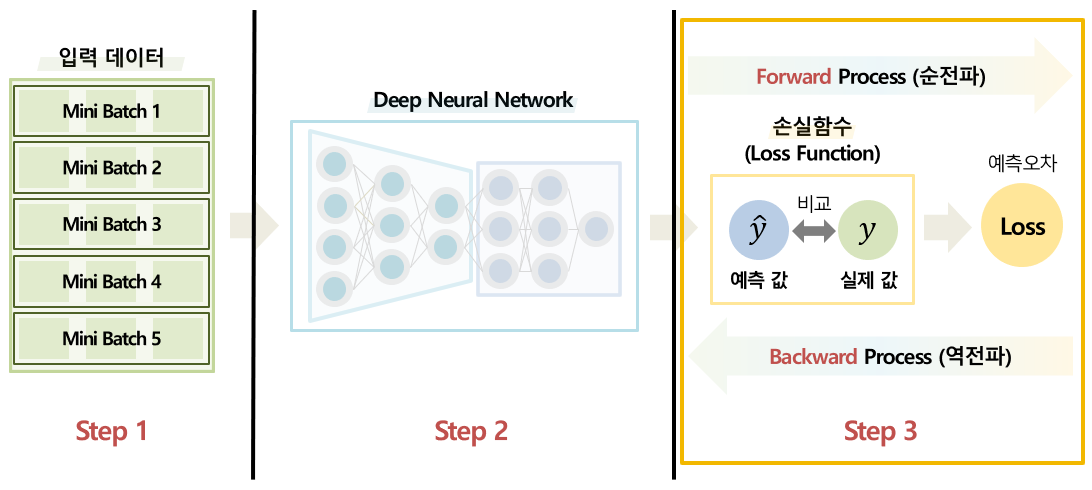

In [79]:
Image('./images/train.PNG')

## 5. Loss Function & Optimizer 정의

### 5-1. Loss Function 정의

In [27]:
criterion = nn.MSELoss()

### 5-2. Optimizer 정의

In [48]:
opt_configs = {
    'optimizer':'adam',
    'lr':1e-2,
    'lr_scheduler':'cosine',   # learning rate scheduler!
    'momentum':0.9,
    'weight_decay':0.0
}

configs.update(opt_configs)

In [29]:
def get_optimizer(configs, model):
    if configs['optimizer'] == "sgd":
        optimizer = optim.SGD(params=model.parameters(), lr=configs['lr'],
                              momentum=configs['momentum'], weight_decay=configs['weight_decay'])

    elif configs['optimizer'] == "adam":
        optimizer = optim.Adam(params=model.parameters(), lr=configs['lr'], 
                                    betas=(configs['momentum'], 0.999), # (momentum, adaptive lr momentum)
                                    weight_decay=configs['weight_decay'])
    else:
        print("Invalid optimizer name, it should be one of ['sgd', 'adam']. Exiting...")
        exit()

    return optimizer

#### [Learning Rate Scheduler](https://gaussian37.github.io/dl-pytorch-lr_scheduler/)
- 학습율을 조정하여서 모델 성능을 최적화
    - 초기 학습 속도 향상 및 학습이 진행됨에 따라 점진적으로 감소시켜 local optima에 빠지는 것을 방지 가능

In [30]:
def get_scheduler(configs, optimizer):
    if configs['lr_scheduler']=="step":
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=configs['num_epochs'], gamma=.5)

    elif configs['lr_scheduler']=="exponential":
        lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.95)

    elif configs['lr_scheduler']=="cosine":
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=configs['num_epochs'], eta_min=configs['lr']*1e-2)
    
    elif configs['lr_scheduler']=='cycle':
        lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=configs['lr'], max_lr=configs['lr']*100, 
                                                   step_size_up=configs['num_epochs']//10, step_size_down=configs['num_epochs']//5,
                                                   mode='exp_range')
    else:
        print("Invalid scheduler name, it should be one of ['step', 'exponential', 'cosine', 'cycle']. Exiting...")
        exit()
        
    return lr_scheduler

## 6. Forward & Backward

### 6-1. 학습에 필요한 하이퍼파라미터 정의

In [50]:
train_configs = {
    'num_epochs':50,
    'save_dir': './results/forecasting/',
    'visualize': True,
    'patience':20  # validation loss가 다시 떨어질 때까지 기다리는 epoch 횟수 (이를 넘으면 모델 저장 후 학습 조기종료)
}

configs.update(train_configs)
configs

{'device': 'cuda',
 'seed': 0,
 'valid_ratio': 0.2,
 'test_ratio': 0.2,
 'scaler': 'standard',
 'window_size': 168,
 'forecasting_size': 168,
 'stride': 1,
 'batch_size': 64,
 'rnn_type': 'LSTM',
 'hidden_size': 64,
 'num_layers': 2,
 'bidirectional': True,
 'dropout_rate': 0.1,
 'teacher_force_prob': 0.5,
 'optimizer': 'adam',
 'lr': 0.01,
 'lr_scheduler': 'cosine',
 'momentum': 0.9,
 'weight_decay': 0.0,
 'num_epochs': 50,
 'save_dir': './results/forecasting/',
 'visualize': True,
 'patience': 20}

### 6-2. Train 과정 함수화

In [32]:
def train(device, model, teacher_forcing_prob, trainloader, criterion, optimizer):
    model.train()
    num_iterations = len(trainloader)
    train_history = {'loss': torch.zeros(num_iterations)}      # 모델의 손실 및 예측 성능을 기록하기 위한 변수
    
    for i, batch in enumerate(trainloader):
        # 인코더 디코더 입출력 데이터 명시, 두 텐서를 모델, 목적함수와 같은 device로
        enc_input, dec_input, y = batch['enc_input'].to(device), batch['dec_input'].to(device), batch['targets'].to(device)

        # forward
        # model에 입력 데이터를 넣으면 자동으로 forward 함수가 호출되어 prediction 값을 output으로 도출
        pred = model(enc_input, dec_input, teacher_forcing_prob)

        # Loss 계산!
        loss = criterion(pred, y)

        """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
        loss.backward()  # PyTorch 자동 미분

        """optimizer를 이용한 파라미터 업데이트"""
        optimizer.step()
        
        """Optimizer Gradient 초기화"""
        optimizer.zero_grad()

        train_history['loss'][i] = loss.item()   # 'item()'은 tensor의 item 값 (상수 값)만 반환. tensor를 직접적으로 리스트에 append하면 불필요하게 메모리가 쌓이는 것 주의.

    train_result = {k: v.mean().item() for k, v in train_history.items()}  # train의 loss, acc를 평균내어 결과 보기 

    return train_result

### 6-3. Valid (Evaluate) 과정 함수화

In [33]:
def evaluate(device, model, validloader, criterion):
    model.eval() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재

    num_iterations = len(validloader)
    valid_history = {'loss': torch.zeros(num_iterations)}      # 모델의 손실(loss) 및 예측 성능을 기록하기 위함
    
    with torch.no_grad():  # 자동미분 연산 중지
        for i, batch in enumerate(validloader):
            enc_input, dec_input, y = batch['enc_input'].to(device), batch['dec_input'].to(device), batch['targets'].to(device)
            pred = model(enc_input, dec_input, teacher_forcing_prob=0.)

            loss = criterion(pred, y)

            """loss를 backward 하지 않는 것에 주의"""

            valid_history['loss'][i] = loss.item()   # 모델 손실 저장

    valid_result = {k: v.mean().item() for k, v in valid_history.items()}

    return valid_result

### 6-4. 모델 학습 추세 시각화 함수

In [34]:
def visualize_model_training(epoch_history):
    # Loss 추세 시각화
    sns.lineplot(x=range(1, len(epoch_history['train_loss'])+1), y=epoch_history['train_loss'], label="Train Loss")
    sns.lineplot(x=range(1, len(epoch_history['train_loss'])+1), y=epoch_history['valid_loss'], label="Valid Loss")
    plt.title("Train vs Valid Loss Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

### 6-5. 학습이 완료된 모델의 파라미터를 저장하는 함수 (조기종료)
- Save parameters of the trained model!
- earlystop!

In [35]:
class EarlyStopping:
    def __init__(self, patience:int=10, 
                verbose:bool=True, 
                delta:float=0.0, 
                save_dir:str="./best_model.pt"):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.save_dir = save_dir

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}).  Saving model ...')
        
        torch.save(model.state_dict(), os.path.join(self.save_dir, 'best_model.pt'))
        self.val_loss_min = val_loss

### 6-6. Test 과정 함수화

In [36]:
def test(device, save_dir, model, testloader):
    """test model 정의"""
    saved_model = torch.load(os.path.join(save_dir, 'best_model.pt')) # 저장된 모델 불러오기
    model.load_state_dict(saved_model)

    """test 과정에서 pred, true를 모두 반환"""
    test_result = {'pred': [], 'true': []}

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            enc_input, dec_input, y = batch['enc_input'].to(device), batch['dec_input'].to(device), batch['targets'].to(device)
            pred = model(enc_input, dec_input, teacher_forcing_prob=0)

            test_result['pred'].extend(pred.squeeze().cpu().numpy())
            test_result['true'].extend(y.squeeze().cpu().numpy())

    return test_result

### 6-7. 모든 학습 프레임워크 함수화
- main 함수를 통해 학습을 수행

In [130]:
def main(configs):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    # Device 정의
    device = configs['device']
    
    # seed 정의
    set_seed(configs['seed'])

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")

    save_dir = os.path.join(configs['save_dir'], configs['rnn_type'])
    # 조기 종료 class 호출 (모델 저장을 위함)
    earlystopping = EarlyStopping(configs['patience'], save_dir=save_dir)
    # 모델 저장을 위한 경로 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    # 데이터 불러오기
    trainloader, validloader, testloader = get_dataloader(configs)
    
    # 모델 정의하기
    model = Seq2Seq(configs, trainloader.dataset.input_dim)
    # GPU로 모델 및 loss function 전송 (CPU에서 계산하는 경우 연산량에 따라 시간이 오래 걸림)
    model, criterion = model.to(device), nn.MSELoss().to(device)

    # optimizer 정의
    optimizer = get_optimizer(configs, model)  # 앞서 정의해두었던 함수 호출
    # lr scheduler 정의
    lr_scheduler = get_scheduler(configs, optimizer)

    # training
    best_loss = float('inf')    # 최종적으로 저장할 모델을 판단할 기준 설정 (초기화)
    best_epoch = 0.0            # 최종 모델이 몇 번째 epoch에서 도출되는지 저장 위함 (초기화)
    epoch_history = {'train_loss': [], 'valid_loss': []}

    start = time.time()

    """Step 2: 학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):  

        print('-'*15, f'Epoch: {epoch}', '-'*15)

        train_result = train(device, model, configs['teacher_force_prob'], trainloader, criterion, optimizer)   # 앞서 정의해두었던 함수 호출
        valid_result = evaluate(device, model, validloader, criterion)           # 앞서 정의해두었던 함수 호출
        lr_scheduler.step()

        print(f"Train Loss: {train_result['loss']:.2f}")
        print(f"Valid Loss: {valid_result['loss']:.2f}")

        """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
        epoch_history['train_loss'].append(train_result['loss'])
        epoch_history['valid_loss'].append(valid_result['loss'])

        """Step 4: 모델을 평가 (valid/eval) 하였을 때 성능 측면에서 가장 우수했던 모델을 저장"""
        earlystopping(valid_result['loss'], model)
        if valid_result['loss'] < best_loss:
            best_loss = valid_result['loss']  # best acc 값 업데이트
            best_epoch = epoch                   # best epoch 값 업데이트

        if earlystopping.early_stop:
            break

    # 최종적으로 선택된 모델에 대한 값 확인
    print(f"Best Valid MSE:{best_loss:.2f} | Best Epoch:{best_epoch}")

    # 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(epoch_history)

    """Step 5: 모델 최종 성능 평가"""
    test_result = test(device, save_dir, model, testloader)

    # 학습/테스트에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return test_result

Configurations: 
 {'device': 'cuda', 'seed': 0, 'valid_ratio': 0.2, 'test_ratio': 0.2, 'scaler': 'standard', 'window_size': 168, 'forecasting_size': 168, 'stride': 1, 'batch_size': 64, 'rnn_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'teacher_force_prob': 0.5, 'optimizer': 'adam', 'lr': 0.01, 'lr_scheduler': 'cosine', 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/forecasting/', 'visualize': True, 'patience': 20}
--------------- Epoch: 1 ---------------
Train Loss: 0.11
Valid Loss: 0.31
Validation loss decreased (inf --> 0.3122).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 0.05
Valid Loss: 1.73
--------------- Epoch: 3 ---------------
Train Loss: 0.04
Valid Loss: 1.17
--------------- Epoch: 4 ---------------
Train Loss: 0.04
Valid Loss: 1.95
--------------- Epoch: 5 ---------------
Train Loss: 0.04
Valid Loss: 1.40
--------------- Epoch: 6 ---------------
Train Loss: 0.04
Valid

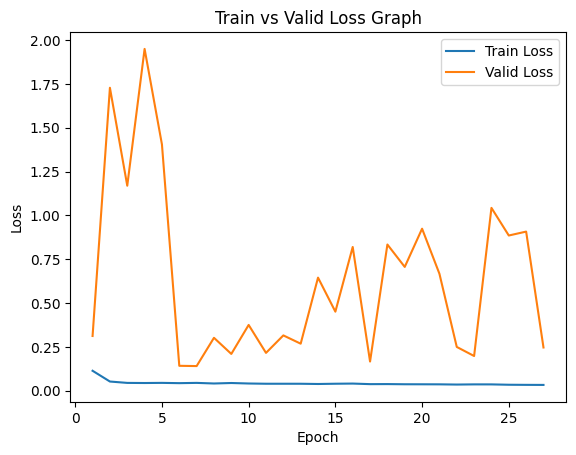

Total Training Time: 10.69 minutes


In [152]:
# 최종 main 함수 실행!!
test_result = main(configs)

### 6-8. Test 결과 확인
- 모델 성능 평가

In [45]:
# Regression Task 평가지표

def return_result(y_true,y_pred):
    performance = dict()
    performance['corr'] = stats.pearsonr(y_true, y_pred)[0]
    performance['r2'] = r2_score(y_true=y_true, y_pred=y_pred)
    performance['mape'] = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    performance['rmse'] = mean_squared_error(y_true=y_true,y_pred=y_pred, squared=True)
    performance['mae'] = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    
    return performance

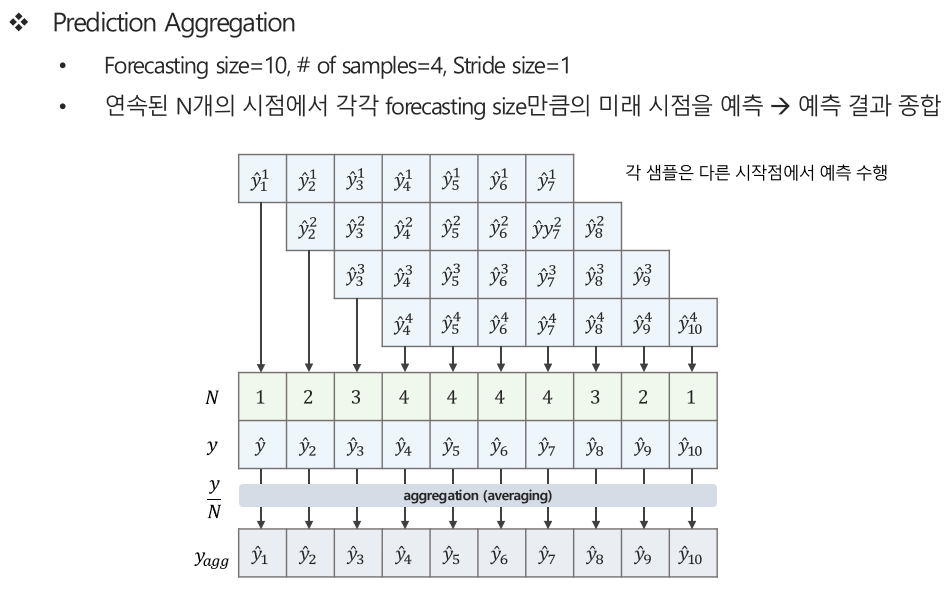

In [6]:
Image('./images/y_agg.PNG')

In [46]:
def agg_y(y: np.ndarray):
    len_time, forecasting_size = y.shape

    y_agg = np.zeros(len(y)+(forecasting_size-1))
    cum = np.zeros(len(y)+(forecasting_size-1))

    for t in range(len_time):
        time_idx = np.arange(forecasting_size) + t

        y_agg[time_idx] += y[t]
        cum[time_idx] += 1

    y_agg /= cum

    return y_agg

In [54]:
true = pd.DataFrame(agg_y(np.array(test_result['true'])))
pred = pd.DataFrame(agg_y(np.array(test_result['pred'])))
date = df.iloc[-true.shape[0]:].date.reset_index(drop=True)

result_df = pd.concat([date, true, pred], axis=1)
result_df.columns = ['date', 'true', 'pred']; result_df

,date,true,pred
0,2018-02-08 16:00:00,-1.621706,-1.512870
1,2018-02-08 17:00:00,-1.571201,-1.572433
2,2018-02-08 18:00:00,-1.630084,-1.576847
3,2018-02-08 19:00:00,-1.697464,-1.565160
4,2018-02-08 20:00:00,-1.705841,-1.549007
...,...,...,...
3311,2018-06-26 15:00:00,-0.729250,-1.363179
3312,2018-06-26 16:00:00,-0.712495,-1.359806
3313,2018-06-26 17:00:00,-0.805008,-1.356482
3314,2018-06-26 18:00:00,-0.864010,-1.353966


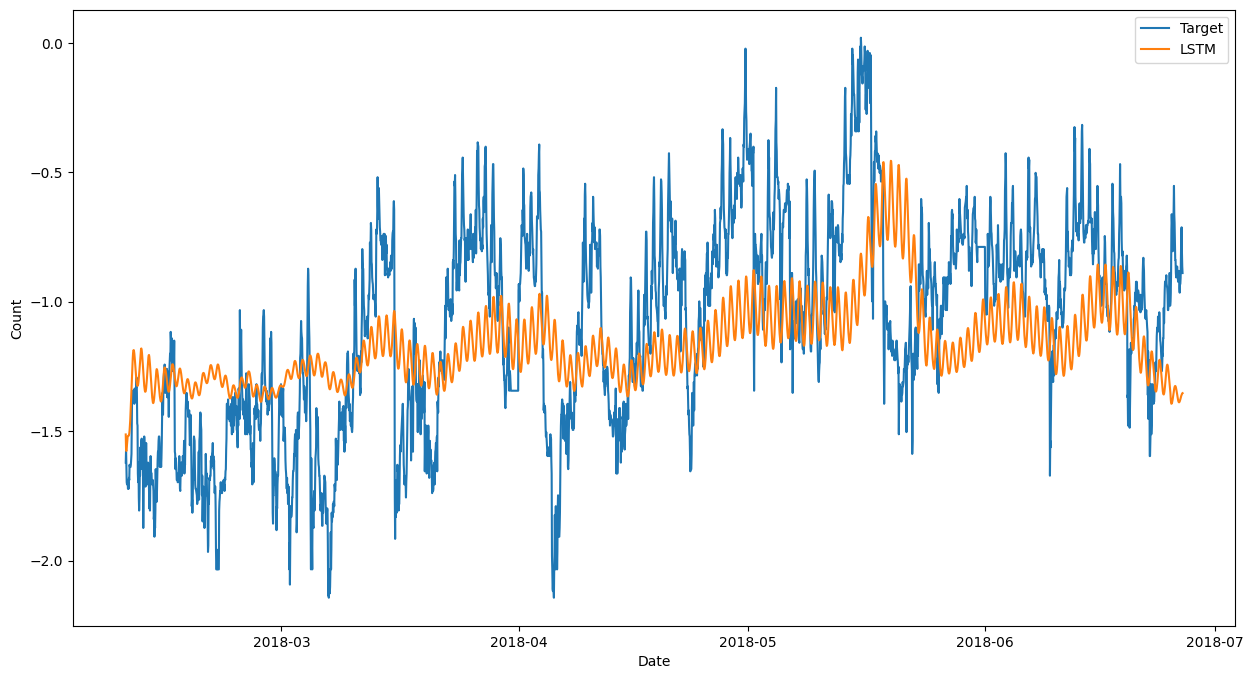

In [303]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(x='date', y='true', data=result_df, label='Target', ax=ax)
sns.lineplot(x='date', y='pred', data=result_df, label=configs['rnn_type'], ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Date')
plt.show()

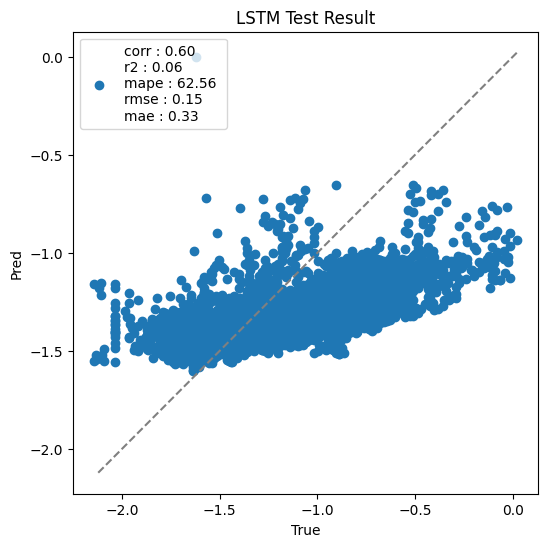

In [153]:
# 시각화

true = agg_y(np.array(test_result['true']))
pred = agg_y(np.array(test_result['pred']))

vmin = np.min(np.concatenate([pred, true])) * 0.99
vmax = np.max(np.concatenate([pred, true])) * 1.01

plt.figure(figsize=(6, 6))
p = return_result(true, pred)
v = list(p.values())
perf_legend = f'corr : {v[0]:.2f} \nr2 : {v[1]:.2f} \nmape : {v[2]:.2f} \nrmse : {v[3]:.2f} \nmae : {v[4]:.2f}'
plt.scatter(true, pred, label=perf_legend)
plt.plot([vmin, vmax], [vmin, vmax], color='grey', linestyle='--')
plt.xlabel('True')
plt.ylabel('Pred')
plt.legend(loc='upper left')
backbone = configs['rnn_type']
plt.title(f"{backbone} Test Result");

------

## Sequence to Sequence with Attention

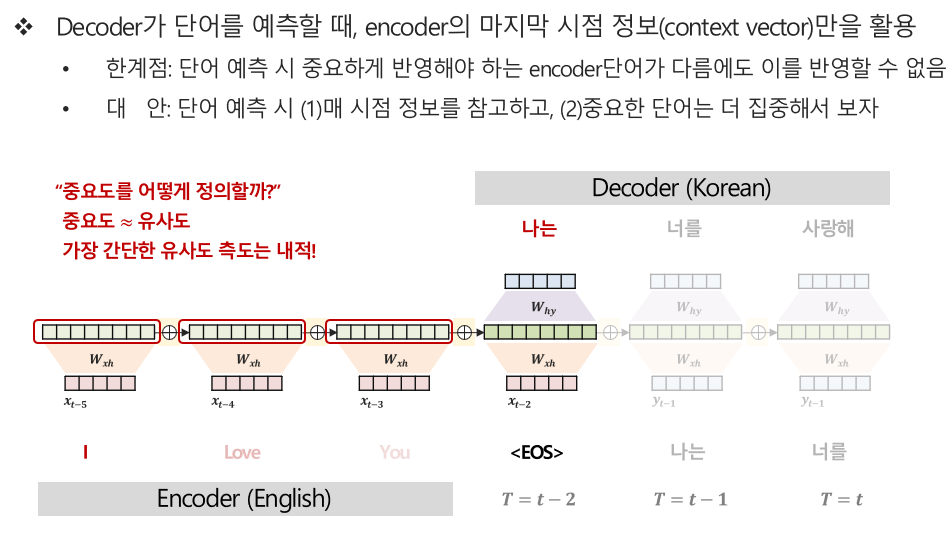

In [2]:
Image('./images/seq2seq-attn.PNG')

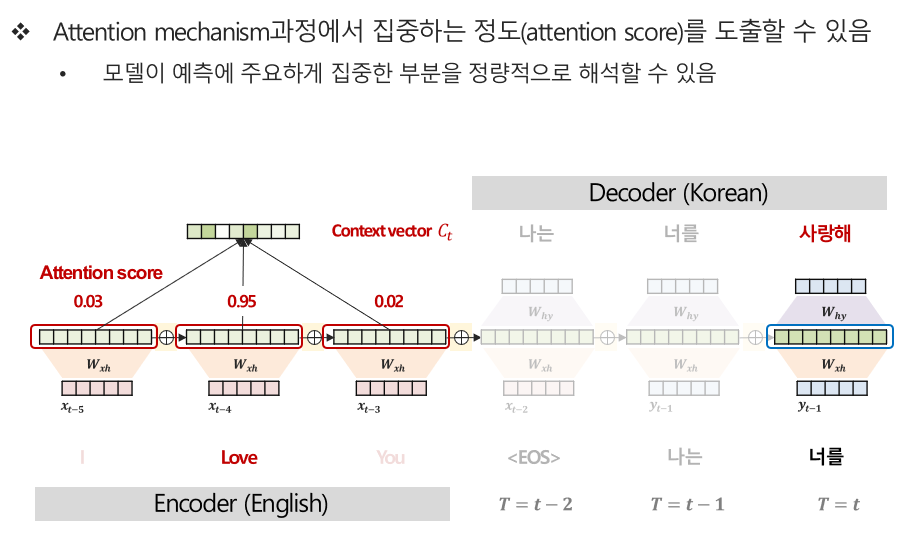

In [4]:
Image('./images/seq2seq-attn2.PNG')

In [278]:
class Encoder(nn.Module):
    def __init__(self, configs, input_dim):
        super(Encoder, self).__init__()
        self.configs = configs
        self.input_dim = input_dim
        self.hidden_size = configs['hidden_size']      # 64
        self.num_layers = configs['num_layers']        # 1
        self.bidirectional = configs['bidirectional']  # True
        self.dropout_rate = configs['dropout_rate']

        self.rnn_type = configs['rnn_type']
        rnn_type_list = ['RNN', 'LSTM', 'GRU']
        assert self.rnn_type in rnn_type_list  # RNN type model이 RNN, LSTM, GRU 중 하나여야 함

        self.encoder = getattr(nn, self.rnn_type)(
            input_size = self.input_dim,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True,
            bidirectional = self.bidirectional,
            dropout = self.dropout_rate
        )

    def forward(self, enc_input):
        # Initial hidden state 초기화
        num_direction = self.num_layers*2 if self.bidirectional else self.num_layers
        h0 = torch.zeros(num_direction, enc_input.size(0), self.hidden_size, device=enc_input.device)

        if self.rnn_type == 'LSTM':
            # lstm의 경우 initial cell state 초기화
            c0 = torch.zeros(num_direction, enc_input.size(0), self.hidden_size, device=enc_input.device)

        # 인코더의 states를 출력하여 반환 (디코더의 init states를 encoder의 것으로 초기화하기 위함)
        init_state = (h0, c0) if self.rnn_type == 'LSTM' else h0
        enc_out, enc_states = self.encoder(enc_input, init_state)
        if self.bidirectional:
            # sum bidirectional outputs
            enc_out = (enc_out[:, :, :self.hidden_size]+
                       enc_out[:, :, self.hidden_size:])

        # 양방향 RNN인 경우: 마지막 layer의 단방향, 역방향 layer state를 결합 (concatenate)
        # 단방향 RNN인 경우: 가장 마지막 timestep에 대한 state 값 
        if self.rnn_type == 'LSTM':
            enc_states = list(enc_states)
            enc_states[0] = enc_states[0][:self.num_layers]  # decoder num_layers만큼 indexing
            enc_states[1] = enc_states[1][:self.num_layers]
            enc_states = (enc_states[0], enc_states[1])
        else:
            enc_states = enc_states[:self.num_layers]

        return enc_out, enc_states

In [279]:
class Attention(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.configs = configs
        self.hidden_size = configs['hidden_size']
        
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        
    def forward(self, hidden, enc_out):
        # last_hidden.unsqueeze(1) -> [B, 1, hidden size]
        # enc_out -> [B, time_step, hidden_size]
        energy = self.attn(enc_out)
        # Compare each encoder hidden state with the current hidden state
        attn_energy = torch.bmm(energy, hidden.transpose(1,2))  # dot-product
        
        # Softmax the attention score to sum them up to 1
        attn_weights = torch.softmax(attn_energy, dim=1)        # [B, time step, 1]
        return attn_weights

In [296]:
class Decoder_Attn(nn.Module):
    def __init__(self, configs):
        super(Decoder_Attn, self).__init__()
        self.configs = configs
        self.hidden_size = configs['hidden_size']      # 64
        self.num_layers = configs['num_layers']        # 1
        self.dropout_rate = configs['dropout_rate']

        self.rnn_type = configs['rnn_type']
        rnn_type_list = ['RNN', 'LSTM', 'GRU']
        assert self.rnn_type in rnn_type_list  # RNN type model이 RNN, LSTM, GRU 중 하나여야 함

        self.teacher_force_prob = configs['teacher_force_prob']  # teacher force를 수행할 확률

        self.decoder = getattr(nn, self.rnn_type)(
            input_size = 1+self.hidden_size,       # hidden size+out_dim
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True,
            bidirectional = False,
            dropout = self.dropout_rate
        )

        self.attention = Attention(configs)

        self.regressor = nn.Linear(in_features=self.hidden_size*2, out_features=1)

    def forward(self, dec_input, states, enc_out):
        hidden = states[0] if self.rnn_type=='LSTM' else states
        
        attn_weights = self.attention(hidden[-1].unsqueeze(1), enc_out)      # [B, time step, 1]
        context_vector = torch.bmm(attn_weights.transpose(1, 2), enc_out)    # [B, 1, hidden size]
        dec_input = torch.cat([dec_input, context_vector], dim=2)            # [B, 1, hidden size+out_dim] (out_dim=1)

        out, states = self.decoder(dec_input, states)                        # out.size() -> [B, 1, hidden_dim]
        out = torch.cat([out.squeeze(1), context_vector.squeeze(1)], dim=1)  # [B, hidden_dim+hiddem_dim]
        
        pred = self.regressor(out)

        return pred, states

In [297]:
class Seq2Seq_Attn(nn.Module):
    def __init__(self, configs, input_dim):
        super(Seq2Seq_Attn, self).__init__()

        self.configs = configs
        self.encoder = Encoder(configs, input_dim)
        self.decoder = Decoder_Attn(configs)

    def forward(self, enc_input, dec_input, teacher_forcing_prob:float=.5):
        # Encode
        enc_out, states = self.encoder(enc_input)

        # initial decoder input
        _dec_input = dec_input[:, 0, :].unsqueeze(-1)   # [B, 1, 1]

        # Store decoder outputs
        preds = torch.zeros(dec_input.size(0), self.configs['forecasting_size'], 1).to(dec_input.device)
        
        for t in range(1, self.configs['forecasting_size']):
            pred, states = self.decoder(_dec_input, states, enc_out)
            preds[:, t] = pred

            # set up input for next timestep
            teacher_force = torch.rand(1).item() < teacher_forcing_prob
            _dec_input = dec_input[:, t, :].unsqueeze(-1) if teacher_force else pred.unsqueeze(-1)

        return preds

In [263]:
def main(configs):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    # Device 정의
    device = configs['device']
    
    # seed 정의
    set_seed(configs['seed'])

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")

    save_dir = os.path.join(configs['save_dir'], configs['rnn_type'])
    # 조기 종료 class 호출 (모델 저장을 위함)
    earlystopping = EarlyStopping(configs['patience'], save_dir=save_dir)
    # 모델 저장을 위한 경로 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    # 데이터 불러오기
    trainloader, validloader, testloader = get_dataloader(configs)
    
    # 모델 정의하기
    model = Seq2Seq_Attn(configs, trainloader.dataset.input_dim)
    # GPU로 모델 및 loss function 전송 (CPU에서 계산하는 경우 연산량에 따라 시간이 오래 걸림)
    model, criterion = model.to(device), nn.MSELoss().to(device)

    # optimizer 정의
    optimizer = get_optimizer(configs, model)  # 앞서 정의해두었던 함수 호출
    # lr scheduler 정의
    lr_scheduler = get_scheduler(configs, optimizer)

    # training
    best_loss = float('inf')    # 최종적으로 저장할 모델을 판단할 기준 설정 (초기화)
    best_epoch = 0.0            # 최종 모델이 몇 번째 epoch에서 도출되는지 저장 위함 (초기화)
    epoch_history = {'train_loss': [], 'valid_loss': []}

    start = time.time()

    """Step 2: 학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):  

        print('-'*15, f'Epoch: {epoch}', '-'*15)

        train_result = train(device, model, configs['teacher_force_prob'], trainloader, criterion, optimizer)     # 앞서 정의해두었던 함수 호출
        valid_result = evaluate(device, model, validloader, criterion)  # 앞서 정의해두었던 함수 호출
        lr_scheduler.step()
        
        print(f"Train Loss: {train_result['loss']:.2f}")
        print(f"Valid Loss: {valid_result['loss']:.2f}")

        """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
        epoch_history['train_loss'].append(train_result['loss'])
        epoch_history['valid_loss'].append(valid_result['loss'])

        """Step 4: 모델을 평가 (valid/eval) 하였을 때 성능 측면에서 가장 우수했던 모델을 저장"""
        earlystopping(valid_result['loss'], model)
        if valid_result['loss'] < best_loss:
            best_loss = valid_result['loss']     # best acc 값 업데이트
            best_epoch = epoch                   # best epoch 값 업데이트

        if earlystopping.early_stop:
            break

    # 최종적으로 선택된 모델에 대한 값 확인
    print(f"Best Valid MSE:{best_loss:.2f} | Best Epoch:{best_epoch}")

    # 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(epoch_history)

    """Step 5: 모델 최종 성능 평가"""
    test_result = test(device, save_dir, model, testloader)

    # 학습/테스트에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return test_result

Configurations: 
 {'device': 'cuda', 'seed': 0, 'valid_ratio': 0.2, 'test_ratio': 0.2, 'scaler': 'standard', 'window_size': 168, 'forecasting_size': 168, 'stride': 1, 'batch_size': 64, 'rnn_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'bidirectional': True, 'dropout_rate': 0.1, 'teacher_force_prob': 0.5, 'optimizer': 'adam', 'lr': 0.01, 'lr_scheduler': 'cosine', 'momentum': 0.9, 'weight_decay': 0.0, 'num_epochs': 50, 'save_dir': './results/forecasting/', 'visualize': True, 'patience': 20}
--------------- Epoch: 1 ---------------
Train Loss: 0.12
Valid Loss: 0.15
Validation loss decreased (inf --> 0.1467).  Saving model ...
--------------- Epoch: 2 ---------------
Train Loss: 0.05
Valid Loss: 0.19
--------------- Epoch: 3 ---------------
Train Loss: 0.04
Valid Loss: 0.78
--------------- Epoch: 4 ---------------
Train Loss: 0.04
Valid Loss: 1.17
--------------- Epoch: 5 ---------------
Train Loss: 0.04
Valid Loss: 0.35
--------------- Epoch: 6 ---------------
Train Loss: 0.04
Valid

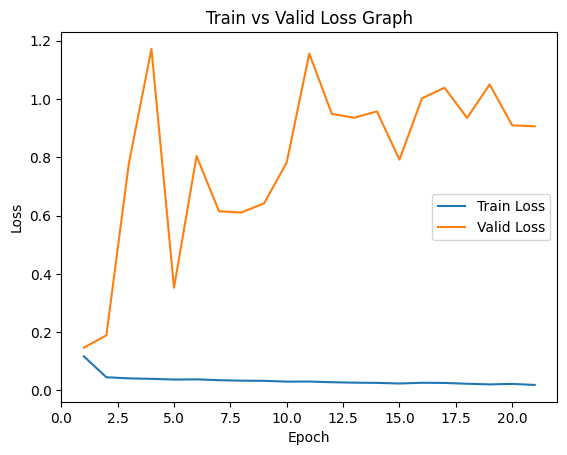

Total Training Time: 15.32 minutes


In [298]:
# 최종 main 함수 실행!!
test_result_attn = main(configs)

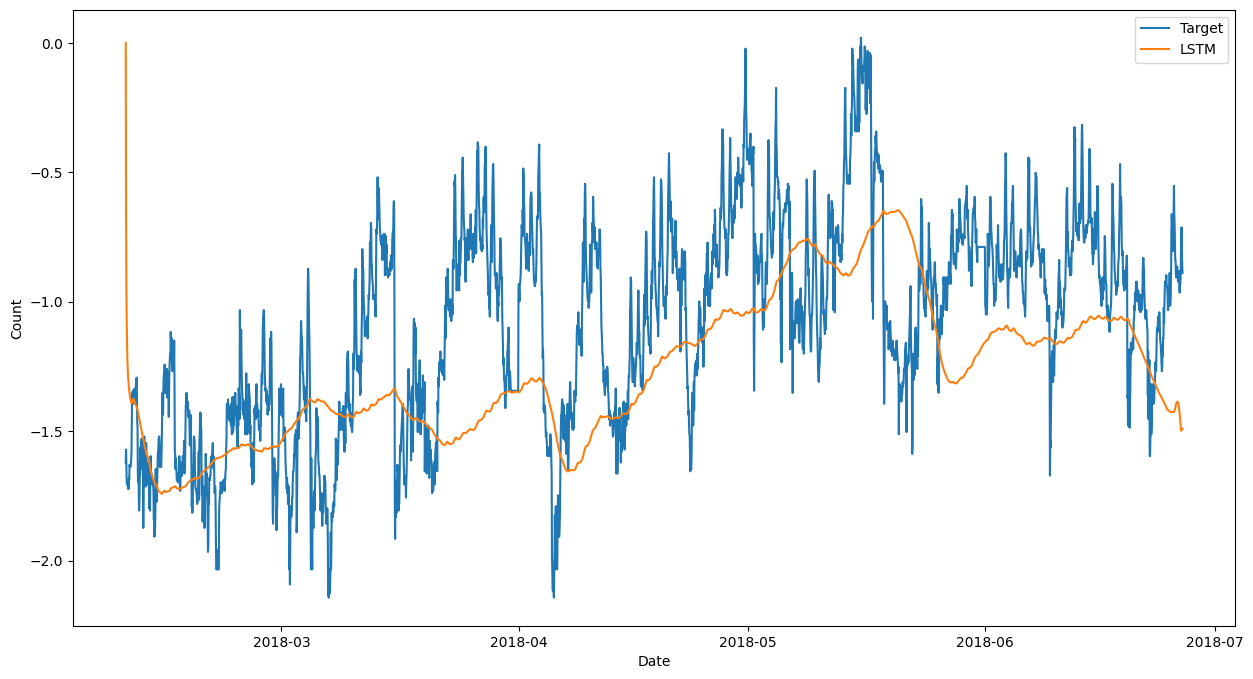

In [301]:
true = pd.DataFrame(agg_y(np.array(test_result_attn['true'])))
pred = pd.DataFrame(agg_y(np.array(test_result_attn['pred'])))
date = df.iloc[-true.shape[0]:].date.reset_index(drop=True)

result_df_attn = pd.concat([date, true, pred], axis=1)
result_df_attn.columns = ['date', 'true', 'pred']

fig, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(x='date', y='true', data=result_df_attn, label='Target', ax=ax)
sns.lineplot(x='date', y='pred', data=result_df_attn, label=configs['rnn_type'], ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Date')
plt.show()

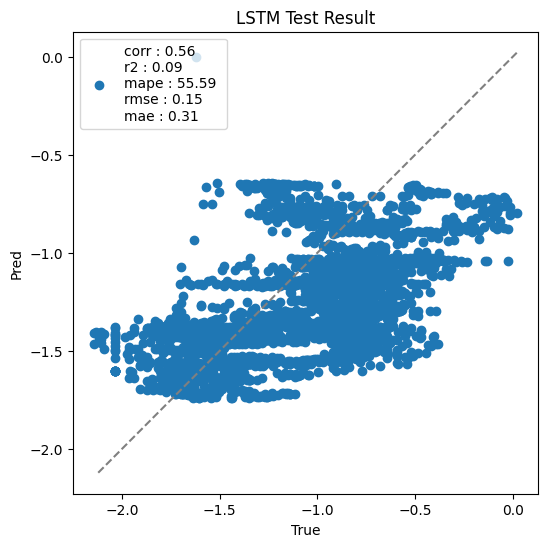

In [299]:
# 시각화

true = agg_y(np.array(test_result_attn['true']))
pred = agg_y(np.array(test_result_attn['pred']))

vmin = np.min(np.concatenate([pred, true])) * 0.99
vmax = np.max(np.concatenate([pred, true])) * 1.01

plt.figure(figsize=(6, 6))
p = return_result(true, pred)
v = list(p.values())
perf_legend = f'corr : {v[0]:.2f} \nr2 : {v[1]:.2f} \nmape : {v[2]:.2f} \nrmse : {v[3]:.2f} \nmae : {v[4]:.2f}'
plt.scatter(true, pred, label=perf_legend)
plt.plot([vmin, vmax], [vmin, vmax], color='grey', linestyle='--')
plt.xlabel('True')
plt.ylabel('Pred')
plt.legend(loc='upper left')
backbone = configs['rnn_type']
plt.title(f"{backbone} Test Result");